In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import requests
import torch
from torch.utils.data import StackDataset,DataLoader,Dataset
from torch import nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable


: 

In [2]:
import tensorflow as tf



In [6]:

class TorchDataset(Dataset):
    def __init__(self, file, root_dir="./", transform=None):
        """
        Arguments:
            file (string): Path to the file with annotations.
            root_dir (string): Directory with all the tfr files.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # to store dictionary for genomic data
        self.df_frame=[]
        # index to select the Upper part of matrix
        indx=[]
        diff=2
        for i in range(448):
          for j in range(i,448):
            if j-i>=2:
              indx.append(448*i+j-diff)
          diff+=3
        self.indx=np.array(indx)
        # print the file currently working on
        print(root_dir+file)
        for rec in tf.data.TFRecordDataset(root_dir+file, compression_type='ZLIB'):
          # Get record bytes
          example_bytes = rec.numpy()
          # Parse example protobuf message
          example = tf.train.Example()
          example.ParseFromString(example_bytes)
          # Iterate example features
          d=dict()
          for key, value in example.features.feature.items():
              if key=="genome":
                  # not necessary for out problem its just 0 for all data
                  #print(value.int64_list.value)
                  d[key]=list(value.int64_list.value)[0]
              if key=="sequence":
                  # seq=list(list(value.bytes_list.value)[0])
                  # They have flattened the one hot endoding we can unflatten it this way
                  # encoding=[]
                  # for i in range(0,len(seq),4):
                  #   encoding.append(seq[i:i+4])
                  # d[key]=encoding
                  d[key]=value.bytes_list.value#bytes(seq)
              if key=="target":
                  '''996810 basically 99681*5*2 (We are predicting just the Upper triangular part(diagonal and 1 off-diagonal is removed) part
                  But they have stored the whole matrix (removing diagonal and 1 off diagonal in both directions)'''
                  #print(len(list(list(value.bytes_list.value)[0])))
                  # seq=list(list(value.bytes_list.value)[0])
                  ### just store it as bytes make processing faster
                  d[key]=value.bytes_list.value#bytes(seq)
              self.df_frame.append(d)

    def __len__(self):
        return len(self.df_frame)
    def findElements(self,lst1, lst2):
      return [lst1[i] for i in lst2]
    def process_seq(self,seq):
      seq=list(list(seq)[0])
      encoding=[]
      for i in range(0,len(seq),4):
        encoding.append(seq[i:i+4])
      return encoding
    def get_ut(self,x):
      return np.array(x)[self.indx.astype(int)]
    def process_target(self,target):
      target=list(list(target)[0])
      l=len(target)
      ans=[]
      for i in range(0,len(target),l//5):
        ans.append(self.get_ut(target[i:i+l//5]))
      return ans
    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      curr=self.df_frame[idx]

      X=self.process_seq(curr["sequence"])
      y=self.process_target(curr["target"])

      sample=(np.array(X).T,np.array(y).T)
      if self.transform:
          sample = self.transform(sample)

      return sample

In [7]:
dataset = TorchDataset(file="train-27.tfr")
dataloader = DataLoader(dataset, batch_size=1,
                        shuffle=True)

./train-27.tfr


In [8]:
for X,y in dataloader:
  print(X.shape,y.shape)
  a=y
  break

torch.Size([1, 4, 1048576]) torch.Size([1, 199362, 5])


In [ ]:
def plot_hic(x):
  mat=torch.zeros(448,448)
  idx=torch.triu_indices(448, 448,2)
  mat[idx[0],idx[1]]=x.float()
  plt.matshow(mat+mat.mT, fignum=False, cmap= 'RdBu_r')
  plt.colorbar(label="Value", orientation="vertical")
  plt.show()

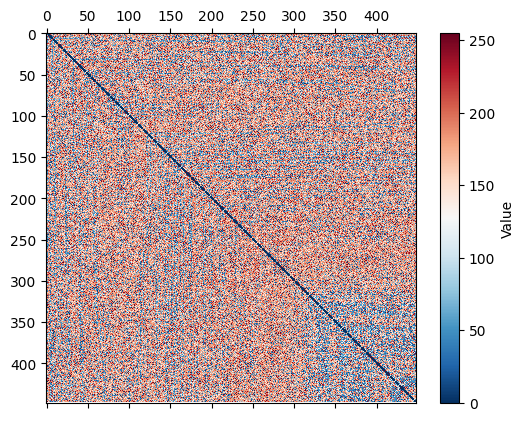

In [ ]:
plot_hic(a[0,:,4])


In [9]:
a.shape

torch.Size([1, 199362, 5])

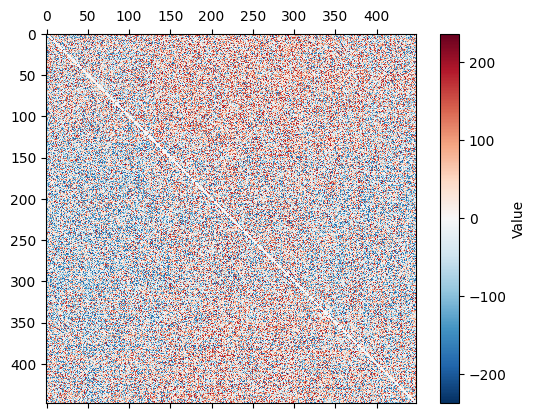

In [13]:
# b=a[:,:,:10]
# print(b)
# b.T.flatten()
# x=a[:,:,3]
# # print(x[:,:100])
# final=torch.zeros((448,448))
# idx=[]
# # # 1 way
# for i in range(448):
#   for j in range(448):
#     if abs(i-j)>=2:
#       idx.append([i,j])
# idx=np.array(idx).T
# # print(idx.shape)
# # # 2 way
# # # idx=torch.concat([torch.tril_indices(448, 448, -2) ,torch.triu_indices(448, 448, 2)],-1)
# final[idx[0],idx[1]]=x.float()
# plt.matshow(final-final.T, fignum=False, cmap= 'RdBu_r')
# plt.colorbar(label="Value", orientation="vertical")
# plt.show()


In [ ]:
def train(net, optimizer, criterion,filename,epochs,root="./",model_name="Akita", plot=False,test_loader=None,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model = net.to(device)
    for name in filename:
      dataset = TorchDataset(file=name,root_dir=root)
      train_loader=DataLoader(dataset, batch_size=1,shuffle=True)
      total_step = len(train_loader)
      overall_step = 0
      train_loss_values = []
      for epoch in range(epochs):
          total = 0
          running_loss = 0.0
          for i, (X, y) in enumerate(train_loader):
              # Move tensors to configured device
              X = X.to(device).float()
              y = y.to(device).float()
              #Forward Pass
              outputs = model(X)
              loss = criterion(outputs, y)
              optimizer.zero_grad()
              loss.backward()
              running_loss += loss.item()
              total += y.size(0)
              optimizer.step()
              if (i+1) % 4 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
              if plot:
                info = { ('loss_' + model_name): loss.item() }
          train_loss_values.append(running_loss/total)

    return train_loss_values

In [ ]:
def train_(net, optimizer, criterion, train_loader, epochs, model_name, plot=False,test_loader=None,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []

    val_loss_values = []
    for epoch in range(epochs):
        total = 0
        running_loss = 0.0
        for i, (X, y) in enumerate(train_loader):
            # Move tensors to configured device
            X = X.to(device).float()
            y = y.to(device).float()
            #Forward Pass
            outputs = model(X)
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            total += y.size(0)
            optimizer.step()
            if (i+1) % 4 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }
        train_loss_values.append(running_loss/total)
        model.eval()
        if test_loader!=None:
          with torch.no_grad():
              correct = 0
              total = 0
              running_loss=0.0
              for i, (X, y) in enumerate(test_loader):
                  X = X.to(device)
                  y = y.to(device)
                  outputs = model(X)
                  loss = criterion(outputs, y)
                  running_loss += loss.item()
                  total += y.size(0)
              val_loss_values.append(running_loss/total)
          print('Accuracy of the network on the test: {} %'.format(100 * correct / total))
    return train_loss_values,val_loss_values

In [ ]:
from typing import Sequence

class Conv1D_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=11,m_kernel=2):
    super().__init__()
    padding=kernel_size//2
    self.conv1d=nn.Conv1d(in_channels, out_channels,kernel_size,padding=padding)
    self.relu1=nn.ReLU()
    self.bn=nn.BatchNorm1d(out_channels)
    self.pool=nn.MaxPool1d(m_kernel,stride=2)
    self.Seq=nn.Sequential(self.relu1,self.conv1d,self.bn,self.pool)
  def __call__(self,x):
    return self.Seq(x)

class ResNet1d(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=5):
    super().__init__()
    padding=kernel_size//2
    self.conv1d1,self.conv1d2=nn.Conv1d(in_channels, out_channels//2,kernel_size,padding=padding),nn.Conv1d(out_channels//2, in_channels,kernel_size,padding=padding)
    self.relu1,self.relu2=nn.ReLU(),nn.ReLU()
    self.Dropout=nn.Dropout()
    self.bn1,self.bn2=nn.BatchNorm1d(out_channels//2),nn.BatchNorm1d(in_channels)
    self.Seq=nn.Sequential(self.relu1,self.conv1d1,self.bn1,self.relu2,self.conv1d2,self.bn2,self.Dropout)
  def __call__(self,x):
    y=x
    return self.Seq(y)+x
class one_two(nn.Module):
  def __init__(self,in_channels, out_channels,mid_channel=64,kernel_size=5,dim=512,device="cpu"):
    super().__init__()
    padding=kernel_size//2
    self.conv1d=nn.Conv1d(in_channels, mid_channel ,kernel_size,padding=padding)
    self.relu1,self.relu2,self.relu3=nn.ReLU(),nn.ReLU(),nn.ReLU()
    self.bn,self.bn1=nn.BatchNorm1d(mid_channel),nn.BatchNorm2d(out_channels)
    self.Seq=nn.Sequential(self.relu1,self.conv1d,self.bn,self.relu2)
    self.conv2d,self.conv2d1=nn.Conv2d(in_channels, mid_channel+1,1),nn.Conv2d(mid_channel+1,out_channels ,kernel_size=5,padding=2)
    self.sem=symmetrize2d()
    self.Seq2=nn.Sequential(self.relu3,self.conv2d1,self.bn1,self.sem)
    l=dim
    a=torch.tensor([list(range(l))])
    b=a.mT
    self.dist=torch.abs(b-a).unsqueeze(0).unsqueeze(0)
    self.dist=self.dist.to(device)
  def __call__(self, x):
    x=self.Seq(x)
    y=torch.cat([torch.add(x.unsqueeze(-1),torch.transpose(x.unsqueeze(-1), -2, -1))/2,self.dist.repeat(x.shape[0],1,1,1)],1)
    return self.Seq2(y)

class conv2d_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size):
    super().__init__()
    padding=kernel_size//2
    self.conv2d=nn.Conv1d(in_channels, out_channels,kernel_size,padding=padding)
    self.relu=nn.ReLU()
    self.bn1=nn.BatchNorm2d(out_channels)
    self.Seq=nn.Sequential(self.relu1,self.conv2d,self.bn1)

  def __call__(self,x):
    x=self.Seq(x)
    return x
class symmetrize2d(nn.Module):
  def __init__(self):
    super().__init__()
  def __call__(self,x):
    return (x+x.transpose(-1,-2))/2

class ResNet2d(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=3):
    super().__init__()
    padding=kernel_size//2
    self.conv2d1,self.conv2d2=nn.Conv2d(in_channels, out_channels//2,kernel_size,padding=padding),nn.Conv2d(out_channels//2, in_channels,kernel_size,padding=padding)
    self.relu1,self.relu2=nn.ReLU(),nn.ReLU()
    self.Dropout=nn.Dropout()
    self.bn1,self.bn2=nn.BatchNorm2d(out_channels//2),nn.BatchNorm2d(in_channels)
    self.Seq=nn.Sequential(self.relu1,self.conv2d1,self.bn1,self.relu2,self.conv2d2,self.bn2,self.Dropout)
  def __call__(self,x):
    y=x
    return self.Seq(y)+x
class Crop2D(nn.Module):
  def __init__(self,length):
    super().__init__()
    self.length=length
  def __call__(self,x):
    return x[:,:,self.length:-self.length,self.length:-self.length]
class Upper_triangle(nn.Module):
  def __init__(self):
    super().__init__()
  def __call__(self,x):
    return x[:,:,torch.triu(torch.ones(x.shape[-1], x.shape[-1]),2) == 1]
class FC(nn.Module):
  def __init__(self,in_f,out_f=5):
    super().__init__()
    self.fc=nn.Linear(in_f,out_f)
  def __call__(self,x):
    return self.fc(x.transpose(-2,-1))

class Model(nn.Module):
  def __init__(self,in_channels,conv1D_block=11,resNet1d=5,resNet2d=5,out=5,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    super().__init__()
    layers=[Conv1D_block(in_channels,96)]
    for i in range(conv1D_block-1):
      layers.append(Conv1D_block(96,96))
    for i in range(resNet1d):
      layers.append(ResNet1d(96,96))
    layers.append(one_two(96,48,device=device))
    for i in range(resNet2d):
      layers.append(ResNet2d(48,48))
      layers.append(symmetrize2d())
    layers.append(Crop2D(32))
    layers.append(Upper_triangle())
    layers.append(FC(48,out))
    self.layers=layers
    self.Seq=nn.Sequential(*self.layers)
  def __call__(self,x):
    # for i in self.layers:
    #   print(x.shape)
    #   x=i(x)
    return self.Seq(x)




In [ ]:
net=Model(4)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
epochs=1
#net, optimizer, criterion,filename,epochs
train_loss_values=train(net, optimizer, criterion,["train-27.tfr"], epochs,model_name="Akita")

./train-27.tfr
Epoch [1/1], Step [4/288], Loss: 20185.3613
Epoch [1/1], Step [8/288], Loss: 16397.9492
Epoch [1/1], Step [12/288], Loss: 14994.1797
Epoch [1/1], Step [16/288], Loss: 5227.0776
Epoch [1/1], Step [20/288], Loss: 4796.3467
Epoch [1/1], Step [24/288], Loss: 4886.5298
Epoch [1/1], Step [28/288], Loss: 4858.6606
Epoch [1/1], Step [32/288], Loss: 4835.2153
Epoch [1/1], Step [36/288], Loss: 4800.5122
Epoch [1/1], Step [40/288], Loss: 4813.1450
Epoch [1/1], Step [44/288], Loss: 4892.0073
Epoch [1/1], Step [48/288], Loss: 4871.8970
Epoch [1/1], Step [52/288], Loss: 4894.9604
Epoch [1/1], Step [56/288], Loss: 4947.3877


KeyboardInterrupt: ignored